<a href="https://colab.research.google.com/github/luancordeiro/lidarpy/blob/main/klett_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

!git clone https://github.com/luancordeiro/lidarpy.git
os.chdir("lidarpy")

Cloning into 'lidarpy'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 621 (delta 88), reused 85 (delta 44), pack-reused 488
Receiving objects: 100% (621/621), 66.90 MiB | 41.93 MiB/s, done.
Resolving deltas: 100% (427/427), done.


# Importing the data

In [2]:
from lidarpy.data.read_binary import GetData

directory = "/content/lidarpy/lidarpy/tests/data/binary"
files = [file for file in os.listdir(directory) if file.startswith("RM")]
files.sort()

data = GetData(directory, files)
lidar_data = data.get_xarray()
lidar_data.shape

(119, 5, 16380)

# Removing the background noise and grouping the bins

In [3]:
from lidarpy.data.manipulation import remove_background, groupby_nbins

nbins = 5

lidar_clean = (lidar_data
               .pipe(remove_background, [25_000, 80_000])
               .pipe(groupby_nbins, nbins))

In [4]:
da_klett = lidar_clean.mean("time")[1, 1100 // nbins:2100 // nbins]
z_klett = da_klett.coords["altitude"]

# Getting the atmospheric data

In [9]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

df_sonde = pd.read_csv("lidarpy/tests/data/sonde_data.txt")

f_temp = interp1d(df_sonde["alt"].to_numpy(), df_sonde["temp"].to_numpy())
f_pres = interp1d(df_sonde["alt"].to_numpy(), df_sonde["pres"].to_numpy())

temperature = f_temp(z_klett)
pressure = f_pres(z_klett)

# Klett inversion

In [10]:
from lidarpy.inversion.klett import Klett

klett = Klett(da_klett, 
              355,
              pressure,
              temperature,
              [9000, 11000],
              19
              )

In [11]:
alpha, beta, lr = klett.fit()

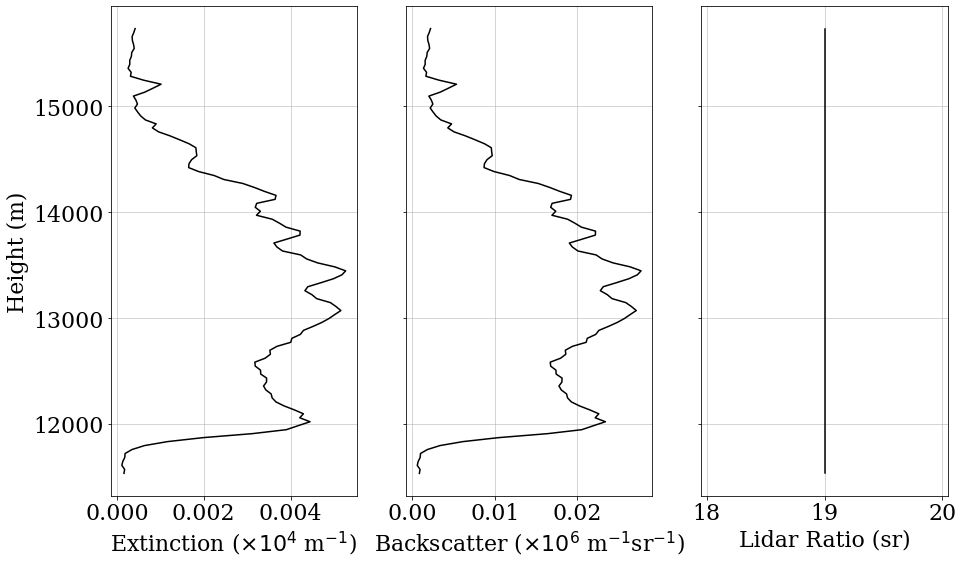

In [12]:
from lidarpy.plot.plotter import plot_3graph_std

ind = (z_klett >= 11500)

plot_3graph_std(z_klett[ind], 
                alpha[ind], 
                beta[ind], 
                lr * np.ones(z_klett.shape)[ind])

# Transmittance

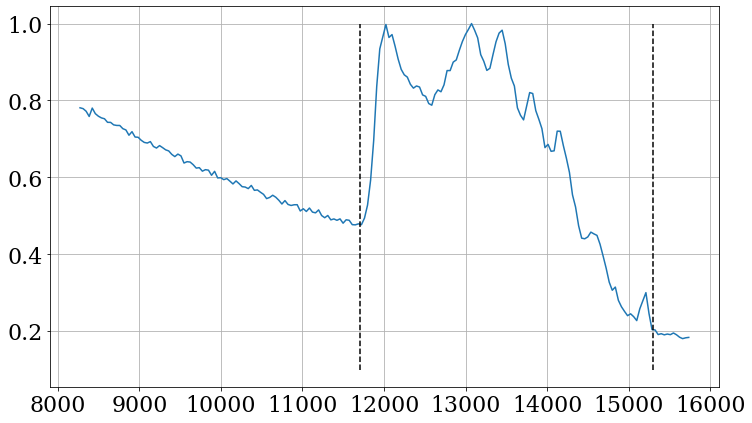

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.plot(da_klett.coords["altitude"], 
         (da_klett.data * da_klett.coords["altitude"] ** 2)
         / max(da_klett.data * da_klett.coords["altitude"] ** 2))

plt.plot([11_700] * 2, [0.1, 1], "k--")
plt.plot([15_300] * 2, [0.1, 1], "k--")
plt.grid()

tau transmittance = 0.27
taus = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
diff = [0.08 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07]


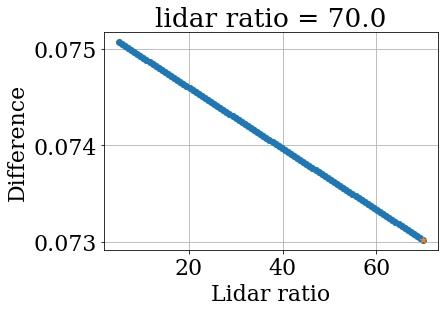

In [25]:
from lidarpy.inversion.klett import Klett

klett = Klett(da_klett, 
              355,
              pressure,
              temperature,
              [9000, 11000],
              z_lims = [11_700, 15_300],
              tau_ind = (da_klett.coords["altitude"].data > 11_600) & (da_klett.coords["altitude"].data < 15_400)
              )